In [12]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 1: 라이브러리 로드 & 함수 정의
# ──────────────────────────────────────────────────────────────────────────────

import warnings
import pandas as pd
import re, json, pathlib
from datetime import date

# konlpy 형태소분석기 (미설치 시 공백 토크나이저로 대체)
try:
    from konlpy.tag import Okt
    okt = Okt()
    STOP = {
        '또는','그리고','및','하지만','그러나','또한','따라서','즉','이하','이상','미만','초과','내외','정도','기준',
        '의한','의하여','의하면','통한','지원','감면','제외','포함','있음','있는','되어','대한','경우','시','후','중',
        '합니다','됩니다','안돼요','안됨','불가능','가능','있습니다','하시기','되어야','되어서','위해','대해','대상','대비','관련','관해'
    }
    def morph(text: str) -> str:
        return " ".join(tok for tok in okt.morphs(str(text)) if tok not in STOP)
except ModuleNotFoundError:
    def morph(text: str) -> str:
        return text

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, util

# 파일 경로 설정
BASE_DIR = pathlib.Path().cwd()  
DATA_FILE = BASE_DIR / "여성맞춤정책_분류+상세_v6.xlsx"
SYN_FILE  = BASE_DIR / "synonyms.json"

# 동의어 사전 로드
with open(SYN_FILE, encoding="utf-8") as f:
    synonym_expansion: dict[str, list[str]] = json.load(f)
_syn_lookup = {w: root for root, words in synonym_expansion.items() for w in words}

# 데이터 로드 및 벡터 준비
_df_base   = pd.read_excel(DATA_FILE, engine="openpyxl")
COLS       = ["지역","제목","신청방법","접수기관","지원대상","지원내용","문의처"]
_base_text = _df_base[COLS].fillna("").agg(" ".join, axis=1)

_morph_vec = TfidfVectorizer(tokenizer=lambda s: s.split(), ngram_range=(1,2), lowercase=False).fit(_base_text)
_char_vec  = TfidfVectorizer(analyzer="char",   ngram_range=(2,4), lowercase=False).fit(_base_text)
_bm25       = BM25Okapi([morph(d).split() for d in _base_text.tolist()])
_sbert      = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
_doc_embs   = _sbert.encode(_base_text.tolist(), convert_to_tensor=True)

# 나이 계산 정규표현식
RE_Y_RANGE  = re.compile(r'(?:만\s*)?(\d+)\s*세\s*[~\-]\s*(?:만\s*)?(\d+)\s*세')
RE_Y_SINGLE = re.compile(r'(?:만\s*)?(\d+)\s*세\s*(이상|초과|미만|이하)')
RE_M_RANGE  = re.compile(r'(\d+)\s*개월\s*[~\-]\s*(\d+)\s*개월')
RE_M_SINGLE = re.compile(r'(\d+)\s*개월\s*(이상|초과|미만|이하)')

def calc_age(dob: str) -> tuple[int|None, int|None]:
    if not dob: return None, None
    y,m,d = map(int, re.split(r'\D+', dob)[:3])
    today = date.today()
    yrs   = today.year - y - ((today.month, today.day) < (m, d))
    mos   = (today.year-y)*12 + (today.month-m) - (1 if today.day<d else 0)
    return yrs, mos

def age_tags(yrs: int) -> set[str]:
    t = set()
    if yrs<=17:    t.add("아동")
    if 9<=yrs<=24: t.add("청소년")
    if 15<=yrs<=39:t.add("청년")
    if 15<=yrs<=49:t.add("가임기여성")
    if yrs>=65:    t.add("노인")
    return t

def age_ok(txt: str, yrs: int|None, mos: int|None) -> bool:
    if yrs is None: return True
    found = False
    for lo,hi in RE_Y_RANGE.findall(txt):
        found = True
        if int(lo)<=yrs<=int(hi): return True
    for v,c in RE_Y_SINGLE.findall(txt):
        found=True; v=int(v)
        if ((c=='이상' and yrs>=v) or (c=='초과' and yrs>v) or
            (c=='이하' and yrs<=v) or (c=='미만' and yrs<v)): return True
    if mos is not None:
        for lo,hi in RE_M_RANGE.findall(txt):
            found=True
            if int(lo)<=mos<=int(hi): return True
        for v,c in RE_M_SINGLE.findall(txt):
            found=True; v=int(v)
            if ((c=='이상' and mos>=v) or (c=='초과' and mos>v) or
                (c=='이하' and mos<=v) or (c=='미만' and mos<v)): return True
    return not found

def _as_list(v):
    if v is None: return []
    if isinstance(v,list): return [x.strip() for x in v if x.strip()]
    return [x.strip() for x in str(v).split(",") if x.strip()]

def sim_mix(q: str, doc: str) -> float:
    vq = hstack((_morph_vec.transform([morph(q)]), _char_vec.transform([q])))
    vd = hstack((_morph_vec.transform([morph(doc)]), _char_vec.transform([doc])))
    return float(cosine_similarity(vq, vd)[0,0])

def search_policies(p: dict) -> pd.DataFrame:
    df = _df_base.copy()
    # 1) __cats 생성
    df["__cats"] = df["카테고리_분류"].fillna("").apply(
        lambda v: {x.strip().replace(" ", "") for x in v.split(",") if x.strip()}
    )
    regions  = [r.strip() for r in _as_list(p.get("region"))]
    cats     = [c.replace(" ", "")      for c in _as_list(p.get("category"))]
    supports = _as_list(p.get("support"))
    kw       = p.get("kw_text","").strip()
    age_y,age_m = calc_age(p.get("dob",""))

    # 2) 나이 태그 OR
    if age_y is not None:
        df["__cats"] = df["__cats"].apply(lambda s: s.union(age_tags(age_y)))
    # 3) 지역 OR
    if not (len(regions)==1 and regions[0]=="전국"):
        df = df[df["지역"].fillna("").apply(lambda v:any(v.startswith(r) for r in regions))]
    # 4) 카테고리 OR
    if cats:
        df = df[df["__cats"].apply(lambda s: bool(set(cats)&s))]
    # 5) 지원형태 OR
    if supports:
        df = df[df["지원형태_분류"].fillna("").apply(
            lambda v: bool(set(x.strip() for x in v.split(",")) & set(supports))
        )]
    # 6) 본문 age_ok
    if age_y is not None:
        agg = df[COLS].fillna("").agg(" ".join, axis=1)
        df  = df[agg.apply(lambda t: age_ok(t, age_y, age_m))]

    # 7) 빈 결과 → 전체 반환
    if df.empty:
        full = _df_base.copy()
        full["combined_score"] = 0.0
        cols = [c for c in full.columns if c!="combined_score"] + ["combined_score"]
        return full.reset_index()[cols]

    # 8) 키워드 스코어링
    tf_scores = df[COLS].fillna("").agg(" ".join,axis=1).apply(lambda d: sim_mix(kw,d)).to_numpy()
    full_bm25  = _bm25.get_scores(morph(kw).split())
    full_sbert = util.cos_sim(_sbert.encode(kw,convert_to_tensor=True), _doc_embs)[0].cpu().numpy()
    idxs       = df.index.to_list()
    bm25_scr   = full_bm25[idxs]
    sbert_scr  = full_sbert[idxs]
    def norm(x): mn,mx = x.min(),x.max(); return (x-mn)/(mx-mn+1e-8)

    df["tf_score"]    = norm(tf_scores)
    df["bm25_score"]  = norm(bm25_scr)
    df["sbert_score"] = norm(sbert_scr)

    df["combined_score"] = 0.2*norm(tf_scores) + 0.3*norm(bm25_scr) + 0.5*norm(sbert_scr)

    # 9) 동의어 매칭 & 정렬
    if (root:=_syn_lookup.get(kw)):
        patt = re.compile("|".join(map(re.escape, synonym_expansion[root])))
        agg  = df[COLS].fillna("").agg(" ".join,axis=1)
        df["syn_match"] = agg.str.contains(patt)
    else:
        df["syn_match"] = False
    df = df[df["syn_match"] | (df["combined_score"]>0)]
    df = df.assign(__syn=df["syn_match"].astype(int))
    df = df.sort_values(by=["__syn","combined_score"], ascending=[False,False])
    df.drop(columns=["__syn","syn_match"], inplace=True)
    
    # 10) 최종 리셋, 재매핑, 드롭, 컬럼 재배치
    df = df.reset_index()  # 기존 행 인덱스를 'index' 컬럼으로 추가
    # …스코어링 및 정렬 로직 끝난 뒤…

    # 11) 인덱스 컬럼 확보 및 카테고리 재매핑
    df["카테고리_분류"] = df["__cats"].apply(lambda s: ",".join(sorted(s)))
    df.drop(columns="__cats", inplace=True)

    # 12) 컬럼 순서 재정렬
    #    - 원본 컬럼들 중 scoring 컬럼을 제외한 뒤,
    #    - tf_score, bm25_score, sbert_score, combined_score 순으로 추가
    scoring_cols = ["tf_score", "bm25_score", "sbert_score", "combined_score"]
    cols = [c for c in df.columns if c not in scoring_cols]
    cols += scoring_cols

    return df[cols]



c:\Users\hyunj\anaconda3\envs\my_env\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
# ──────────────────────────────────────────────────────────────────────────────
# Cell 2: 실행 예시 & 결과 저장
# ──────────────────────────────────────────────────────────────────────────────

params = {
    'region'   : '전국',
    'category' : '1인가구,임신/출산/육아,한부모',
    'support'  : '직접금전지원,교육지원',
    'dob'      : '2000.05.05',
    'kw_text': '한부모 가정의 대학생이 받을 수 있는 의료 서비스, 자원봉사 기회, 교육 프로그램, 주거 내 지원, 영양 식품 보조 등 전반적인 생활 지원 정책'
}

result = search_policies(params)
result.to_excel('search_result.xlsx', index=False)
print("검색 완료: search_result.xlsx")


검색 완료: search_result.xlsx


In [14]:
result.head(20)

,index,대상유형,지역,제목,detail_url,신청기간,신청방법,접수기관,지원형태,지원대상,...,문의처,기타,카테고리_분류,category_matched_kw,지원형태_분류,support_matched_kw,tf_score,bm25_score,sbert_score,combined_score
0,753,한부모,울산광역시교육청,교육복지 우선 지원,https://www.gov.kr/portal/rcvfvrSvc/dtlEx/7480...,상시신청,사업학교별로 참여 학생 모집 시 신청(학교별 신청 절차가 다름),울산광역시교육청,"서비스(돌봄), 기타(교육)","지원대상\n기초생활보장 수급자 학생, 차상위 계층 학생, 한부모가족 보호 대상 학생...",...,NaN,NaN,"가임기여성,다문화,대학(원)생,임신/출산/육아,청년,취약계층,한부모","한부모,보육,대학생,다문화,취약계층","교육지원,의료지원,생계지원,상담지원,문화예술,서비스","교육,예방,식비,상담,문화,서비스",0.968906,0.947529,0.957573,0.956826
1,1091,한부모,전라남도교육청,교육복지 우선 지원,https://www.gov.kr/portal/rcvfvrSvc/dtlEx/8490...,상시신청,방문신청,전라남도교육청,"서비스(돌봄), 기타(교육)",지원대상\n저소득층이 밀집한 학교에 재학하는 우선 지원 학생\n ※우선 지원 학생:...,...,안전복지과 교육복지팀 (☎061-260-0311),NaN,"가임기여성,다문화,청년,취약계층,한부모","한부모,다문화,저소득","교육지원,상담지원,문화예술,서비스","교육,상담,문화,서비스",0.828609,0.873210,0.951653,0.903511
2,823,한부모,전국,교육복지우선지원,https://www.gov.kr/portal/rcvfvrSvc/dtlEx/WII0...,접수기관 별 상이,○ 접수기관에 문의,시도교육청 교육복지우선지원사업 소관부서,"서비스(돌봄), 기타(교육)","지원대상\n○ 수급자 학생, 교육감이 정하는 차상위 계층 학생, 한 부모 가족 보호...",...,관할 시도교육청 (☎-),NaN,"가임기여성,다문화,대학(원)생,임신/출산/육아,청년,초/중/고등학생,취약계층","보육,초등,대학생,다문화,취약계층","교육지원,의료지원,생계지원,상담지원,문화예술,서비스","교육,예방,식비,상담,문화,서비스",1.000000,1.000000,0.723105,0.861552
3,452,한부모,대구광역시,가사·간병 방문 지원,https://www.gov.kr/portal/rcvfvrSvc/dtlEx/6270...,접수기관 별 상이,○ 방문 신청\n - 주민센터 : 거주지 관할 읍면동 주민센터에 방문 신청,주민센터,이용권,"지원대상\n○ 만65세 미만의 생계·의료·주거·교육급여 수급자, 차상위계층, 기준 ...",...,복지정책과 복지서비스팀 (☎053-803-6252),NaN,"가임기여성,임신/출산/육아,청년,취약계층,한부모","한부모,양육,질환자","직접금전지원,이용권,상담지원,서비스","지원금,이용권,상담,서비스",0.915857,0.981109,0.730105,0.842556
4,727,한부모,세종특별자치시교육청,취약계층 학생 교육복지안전망 우선지원,https://www.gov.kr/portal/rcvfvrSvc/dtlEx/9300...,별도의 신청절차가 없음,"O 학교장 추천 신청\n(부모 동의서, 교사 추천서, 학생 욕구조사서 첨부)",NaN,"현금, 현물, 기타(교육)","지원대상\n- 국민기초생활수급자, 법정 차상위 대상자, 한부모가족보호대상자, 중위소...",...,학교지원본부 교육지원부 박현호 (☎044-903-8014),NaN,"가임기여성,청년,취약계층,한부모","한부모,취약계층","직접금전지원,교육지원,의료지원,물품지원,문화예술","현금,교육,의료,용품,문화",0.815073,0.685814,0.890295,0.813906
5,843,임산부,전국,농식품바우처 지원,https://www.gov.kr/portal/rcvfvrSvc/dtlEx/B552...,25.2.17.~'25.12.12.,○ 온라인 신청: 농식품바우처 누리집 회원가입을 통한 신청\n○ ARS 신청: 대표...,"주민센터,보건소,시·군·구청",이용권,지원대상\n(지원대상) ‘소득 기준’과 ‘특성 기준’을 모두 충족한 가구\n - (...,...,고객지원센터 (☎1551-0857)\n농식품바우처TF (☎061-931-1094),NaN,"가임기여성,임신/출산/육아,청년,초/중/고등학생,취약계층","영유아,초등학생,취약계층","이용권,교육지원","이용권,교육",0.727042,0.929015,0.748647,0.798437
6,830,한부모,전국,국민취업지원제도,고용24(www.work24.go.kr),상시 신청,고용24 온라인 신청 또는 고용센터 방문,"관할 고용센터 또는 온라인(워크넷, 고용24)","직업훈련, 일경험, 복지서비스 연계, 취업알선 등","근로능력과 구직의사가 있는 15~69세 이하의 저소득층, 미혼모, 한부모 등",...,고용노동부 상담센터(☎1350),NaN,"가임기여성,구직/취업,청년,취약계층,한부모","한부모,취업,장애","직접금전지원,서비스","수당,서비스",0.582765,0.536824,1.000000,0.777600
7,566,한부모,서울특별시,가사·간병 방문 지원,https://www.gov.kr/portal/rcvfvrSvc/dtlEx/6110...,상시신청,○ 방문 신청 및 온라인 신청\n - 주민센터 : 연중 대상자 주민등록 주소지 관할...,주민센터,이용권,지원대상\n○ 만 65세 미만의 기준중위소득 70% 이하 계층 중 아래에 해당하는 ...,...,관할 주민센터 (☎02-120),NaN,"가임기여성,고령자,임신/출산/육아,청년,취약계층,한부모","한부모,양육,노인,질환자","직접금전지원,이용권,교육지원,의료지원,주거지원,상담지원,서비스","지원금,이용권,교육,의료,주거,상담,서비스",0.844789,0.836834,0.706898,0.773457
8,915,여성,전국,여성장애인 교육지원,https://www.gov.kr/portal/rcvfvrSvc/dtlEx/GMW0...,연중신청가능,읍면동 및 사업 수행기관 방문 신청,보건복지부콜센터,기타(교육),지원대상\n○ 등록 여성장애인\n선정기준\n○ 장애인복지법 제32조(장애인 등록)에...,...,해당지역 시군구청 (☎126),NaN,"가임기여성,임신/출산/육아,청년,취약계층","산모,장애","교육지원,상담지원,문화예술,법률지원","교육,상담,문화,법률",0.763799,0.656683,0.843405,0.771467
9,31,임산부,강원특별자치도/영월군,영양플러스 보충식품 지원,https://www.gov.kr/portal/rcvfvrSvc/dtlEx/4270...,상시신청,○ 방문 신청\n - 보건소 : 관할 보건소 방문,보건소,"현물, 기타(교육), 기타(상담)","지원대상\n○ 대상구분: 임산부(임신ㆍ출산ㆍ수유부), 만 6세(72개월)까지의 영유...",...,영월군보건소 영양플러스실 (☎033-370-5456),NaN,"가임기여성,임신/출산/육아,청년,취약계층","출산,취약계층","교육지원,상담지원,물품지원","교육,상담,현물",0.687331,0.940181,0.698813,0.768927


c:\Users\hyunj\anaconda3\envs\my_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\hyunj\anaconda3\envs\my_env\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Query: 한부모 가정의 대학생이 받을 수 있는 의료 서비스, 자원봉사 기회, 교육 프로그램, 주거 내 지원, 영양 식품 보조 등 전반적인 생활 지원 정책


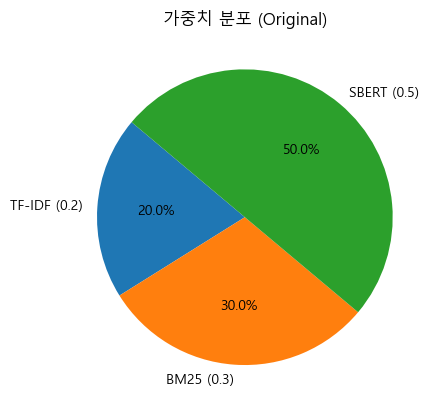

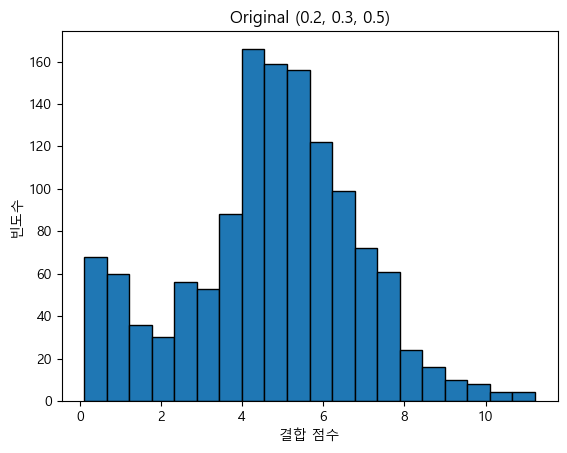

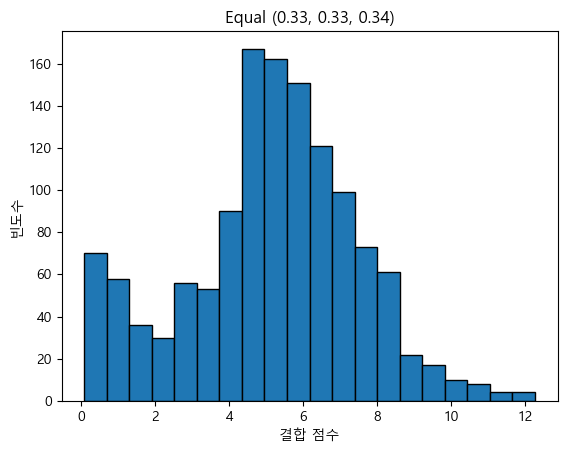

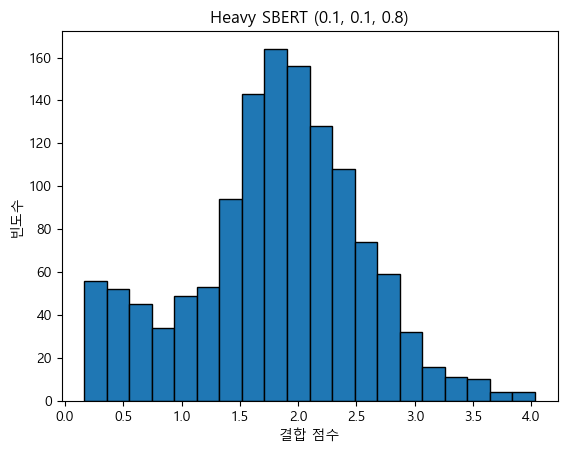

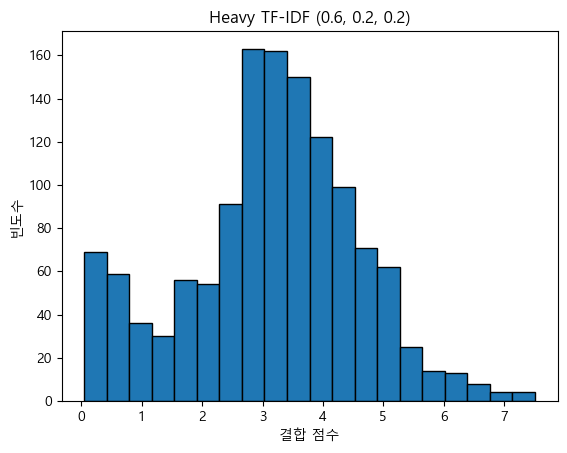

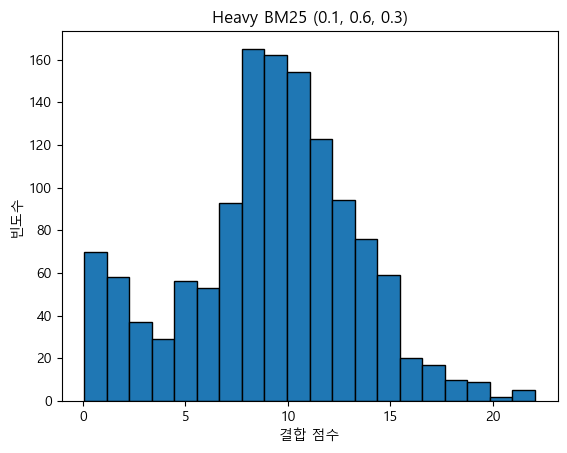

완료: search_with_individual_scores_updated.xlsx


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, util
from konlpy.tag import Okt
import re

# 한글 폰트 설정 (Windows 예시: 'Malgun Gothic')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 축 마이너스 표시 깨짐 방지

# 1) Load search results
result = pd.read_excel("여성맞춤정책_분류+상세_v6.xlsx", engine="openpyxl")

# 2) Prepare tokenizers, vectorizers, and models
okt = Okt()
STOP = {'또는','그리고','및','지원','감면','제외','포함','경우','관련','사항'}
def morph(text: str) -> str:
    return " ".join(tok for tok in okt.morphs(str(text)) if tok not in STOP)

COLS = ["지역","제목","신청방법","접수기관","지원대상","지원내용","문의처"]
all_texts = result[COLS].fillna("").agg(" ".join, axis=1).tolist()

tfidf_word = TfidfVectorizer(tokenizer=lambda s: s.split(), ngram_range=(1,2), lowercase=False)
tfidf_char = TfidfVectorizer(analyzer="char", ngram_range=(2,4), lowercase=False)
tfidf_word.fit(all_texts)
tfidf_char.fit(all_texts)

bm25 = BM25Okapi([morph(t).split() for t in all_texts])

sbert = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
doc_embeddings = sbert.encode(all_texts, convert_to_tensor=True)

# 3) Compute individual scores for the query
kw = (
    "한부모 가정의 대학생이 받을 수 있는 의료 서비스, "
    "자원봉사 기회, 교육 프로그램, 주거 내 지원, 영양 식품 보조 등 전반적인 생활 지원 정책"
)
print("Query:", kw)

def sim_mix(q: str, doc: str) -> float:
    vq = hstack((tfidf_word.transform([morph(q)]), tfidf_char.transform([q])))
    vd = hstack((tfidf_word.transform([morph(doc)]), tfidf_char.transform([doc])))
    return float(cosine_similarity(vq, vd)[0,0])

tfidf_scores = [sim_mix(kw, d) for d in all_texts]
bm25_scores  = bm25.get_scores(morph(kw).split())
query_emb    = sbert.encode(kw, convert_to_tensor=True)
sbert_scores = util.cos_sim(query_emb, doc_embeddings)[0].cpu().numpy()

result["tfidf_score"] = tfidf_scores
result["bm25_score"]  = bm25_scores
result["sbert_score"] = sbert_scores

# 4) Plot original weight distribution
weights = {"TF-IDF (0.2)": 0.2, "BM25 (0.3)": 0.3, "SBERT (0.5)": 0.5}
plt.figure()
plt.pie(weights.values(), labels=weights.keys(), autopct="%1.1f%%", startangle=140)
plt.title("가중치 분포 (Original)")
plt.show()

# 5) Scenario histograms including Heavy BM25
def compute_combined(df, w):
    return w[0]*df["tfidf_score"] + w[1]*df["bm25_score"] + w[2]*df["sbert_score"]

scenarios = {
    "Original (0.2, 0.3, 0.5)": (0.2, 0.3, 0.5),
    "Equal (0.33, 0.33, 0.34)": (0.33, 0.33, 0.34),
    "Heavy SBERT (0.1, 0.1, 0.8)": (0.1, 0.1, 0.8),
    "Heavy TF-IDF (0.6, 0.2, 0.2)": (0.6, 0.2, 0.2),
    "Heavy BM25 (0.1, 0.6, 0.3)": (0.1, 0.6, 0.3)
}

for name, w in scenarios.items():
    result[name] = compute_combined(result, w)
    plt.figure()
    plt.hist(result[name], bins=20, edgecolor="black")
    plt.title(name)
    plt.xlabel("결합 점수")
    plt.ylabel("빈도수")
    plt.show()

# 6) Save updated sheet
result.to_excel("search_with_individual_scores_updated.xlsx", index=False)
print("완료: search_with_individual_scores_updated.xlsx")


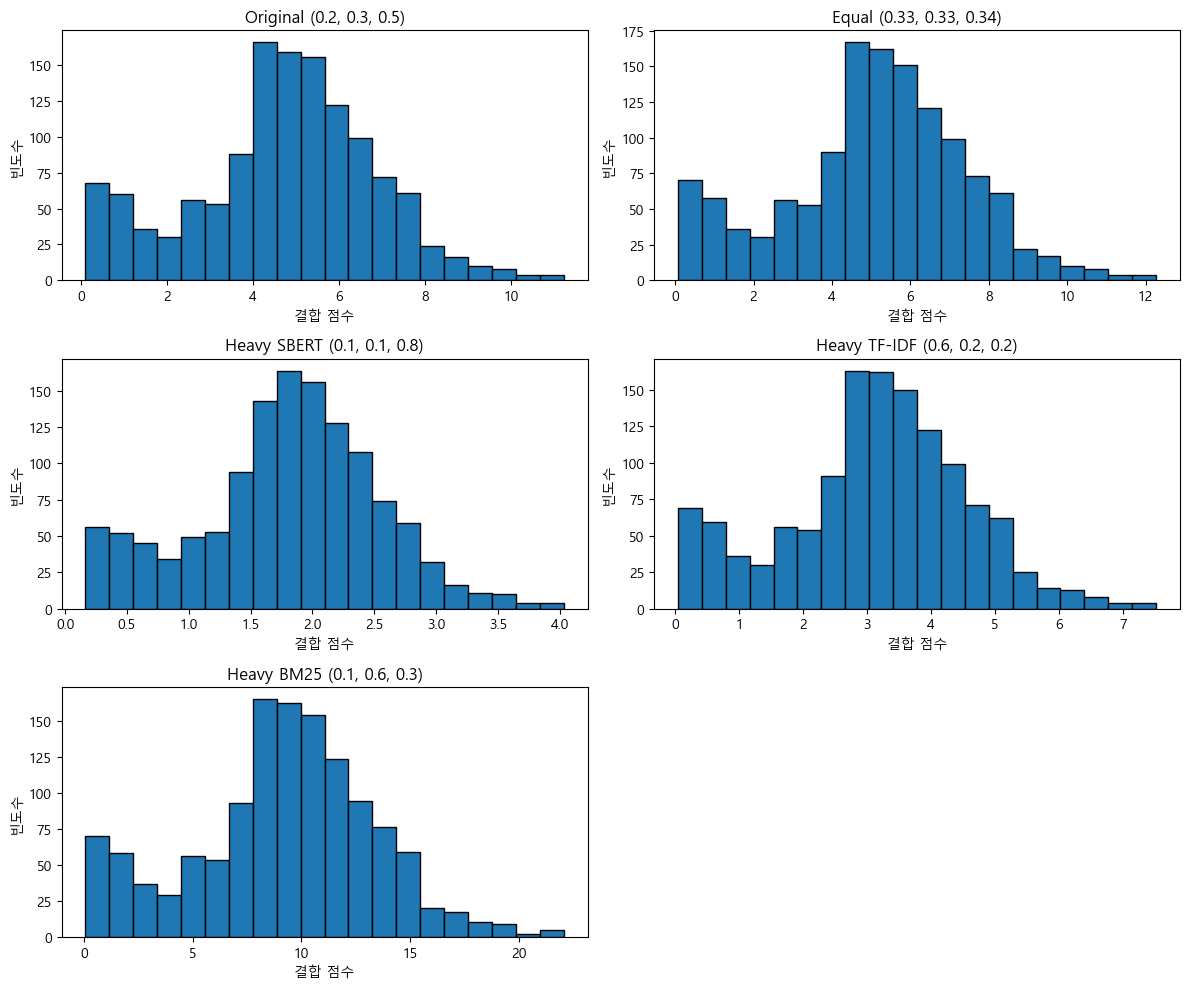

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer, util
from konlpy.tag import Okt
import re

# 한글 폰트 설정 (Windows 예시: 'Malgun Gothic')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1) Load search results
df = pd.read_excel("search_with_individual_scores_updated.xlsx", engine="openpyxl")

# 2) Ensure individual score columns exist
# Already computed in prior step:
# df["tfidf_score"], df["bm25_score"], df["sbert_score"]

# 3) Define scenarios including Heavy BM25
scenarios = {
    "Original (0.2, 0.3, 0.5)": (0.2, 0.3, 0.5),
    "Equal (0.33, 0.33, 0.34)": (0.33, 0.33, 0.34),
    "Heavy SBERT (0.1, 0.1, 0.8)": (0.1, 0.1, 0.8),
    "Heavy TF-IDF (0.6, 0.2, 0.2)": (0.6, 0.2, 0.2),
    "Heavy BM25 (0.1, 0.6, 0.3)": (0.1, 0.6, 0.3)  # 추가된 시나리오
}

def compute_combined(df, weights):
    return (
        weights[0] * df["tfidf_score"] +
        weights[1] * df["bm25_score"] +
        weights[2] * df["sbert_score"]
    )

# 4) Plot histograms for each scenario
plt.figure(figsize=(12, 10))
for i, (name, w) in enumerate(scenarios.items(), start=1):
    df[name] = compute_combined(df, w)
    plt.subplot(3, 2, i)
    plt.hist(df[name], bins=20, edgecolor="black")
    plt.title(name)
    plt.xlabel("결합 점수")
    plt.ylabel("빈도수")

plt.tight_layout()
plt.show()
